In [1]:
#https://github.com/16gs24/instacart-embeddings/tree/master

In [2]:
# Finding similarites in items in instacart dataset from Kaggle

In [102]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# loading datasets from instacart dataset

orders = (pd.read_csv('./data/order_products__train.csv')
          ._append(pd.read_csv('./data/order_products__prior.csv'))
         )
products = pd.read_csv('./data/products.csv')

In [104]:
relevant_cols = ['order_id','product_name']

#downsample while I test the code for faster iteration on syntax. run full dataset before commit.
sample_size = 1

baskets = (orders
           .merge(products,on='product_id',how='left')
           .sample(frac=sample_size)
          )[relevant_cols]

#memory management on my local computer
#del([orders,products])

In [ ]:
# Count the occurrences of each word
# we have a problem because there are many products sold a few times, 
# this does not help with the embeddings
baskets.product_name
item_counts = baskets['product_name'].value_counts()
df_counts = item_counts.to_frame().reset_index()

df_counts

In [105]:
baskets.sort_values(['order_id']).head(20)

,order_id,product_name
4,1,Lightly Smoked Sardines in Olive Oil
7,1,Organic Whole String Cheese
3,1,Cucumber Kirby
2,1,Organic Celery Hearts
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
5,1,Bag of Organic Bananas
6,1,Organic Hass Avocado
0,1,Bulgarian Yogurt
1384620,2,Coconut Butter
1384619,2,Garlic Powder


### Embedding Size

This will matter as we use gensim's word2vec implementation for this task. The learning task for word2vec is predicting the a missing word given a window of words around it using a single hidden layer.  Rather than caring about the quality of the prediction, the weights of the hidden layer are what represent the product embedding that we will use. The number of neurons in the hidden layer is a tunable parameter. Unfortunately, there isn't great guidance on select for this, but eyeballing the resulting embeddings can give guidance on quality of fit. Some people recommend using the 4th root of unique tokens in our corpus, which I'll try.

A tunable parameter for the algorithm is the context window, how many words around the target word to use for our prediction task. Given the lack of order, we will want to use the size of the largest basket, 145 for this parameter.

In [9]:
num_items = baskets.product_name.nunique()
embedding_size = np.floor(num_items**0.25).astype('int')
print('''Let's use vectors of length {n} for {tokens} products'''.format(n=embedding_size, 
                                                                         tokens = num_items))

biggest_basket = np.max(baskets.groupby('order_id').product_name.nunique())
print('''The biggest basket (window in our algorithm) will be {}'''.format(biggest_basket))

Let's use vectors of length 14 for 49685 products
The biggest basket (window in our algorithm) will be 145


### Shaping our Data
The gensim implementation of word2vec expects each document to be a list. Traditionally, each document is a list of words. In this case, each basket is a list of products. We will use the product name, which will be more expensive in memory but will make interpretation easier.

In [10]:
df_of_basket_lists = (baskets
        .groupby('order_id')
        .apply(lambda baskets :
                baskets.product_name.tolist()
               )
       )

#memory management
#del(baskets)

In [12]:
df_of_basket_lists.head()

order_id
1    [Cucumber Kirby, Bag of Organic Bananas, Organ...
2    [Organic Egg Whites, Michigan Organic Kale, Ca...
3    [Organic Ezekiel 49 Bread Cinnamon Raisin, Uns...
4    [Original Orange Juice, Kellogg's Nutri-Grain ...
5    [Biscuits Orange Pim's, Meyer Lemon, American ...
dtype: object

In [13]:
print(len(df_of_basket_lists))

3346083


In [64]:
model = Word2Vec(df_of_basket_lists, vector_size=embedding_size, window=biggest_basket, min_count=1)

In [65]:
def cosine_similarity(word_u,word_v,model):
    """
    Cosine similarity gets the similarity for two products and computes the similarity 
    between two embeddings in our word2vec model
        
    Arguments:
        u - numpy array of shape (n,)        
        v - numpy array of shape (n,)

    Returns:
        cosine similarity between words u & v
    """
    #get embeddings from gensim model
    u = model.wv[word_u]
    v = model.wv[word_v]

    #compute similarity
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u * u))
    norm_v = np.sqrt(np.sum(v * v))
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

In [66]:
model.wv['Charcoal Briquets Easy Light Bag']

array([-0.2234447 , -0.02080378,  0.0138538 ,  0.1951637 , -0.1483195 ,
        0.03569596, -0.00202972,  0.0989695 ,  0.0375315 , -0.0470693 ,
       -0.17808595, -0.07264414, -0.00224825, -0.26662764], dtype=float32)

In [67]:
#a pair of similar identity items
cosine_similarity('Organic Whole Milk','Organic Reduced Fat Milk',model)

0.9449954

In [68]:
# a pair of similar items within a department
cosine_similarity('Bag of Organic Bananas','Limes',model)

0.36388174

In [69]:
# a pair of very different items
cosine_similarity('Bag of Organic Bananas','Party Tumblers',model)

-0.40542653

In [70]:
cosine_similarity('100% Columbian Coffee', 'Coffee Liqueur', model)

0.5543359

In [71]:
cosine_similarity('100% Columbian Coffee', 'Natural Cane Turbinado Sugar', model)

-0.063098915

In [72]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.index_to_key), sample)
#            words = np.random.choice(list(model.vocab.keys()), sample)

        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(16,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [73]:
model.wv.most_similar('Chicken Fingers')


[('Rainforest Blend Coffee K-Cups', 0.9190124869346619),
 ('Organic Bucatini', 0.9058505892753601),
 ('Honey Crisp Apple Juice', 0.9007980823516846),
 ('Coffee Cake Bites', 0.8681004047393799),
 ('Mini Croissant', 0.8622719645500183),
 ('Brioche Tressee Slice Loaf', 0.840765118598938),
 ('Vanilla Bean & Honey Yogurt Protein Drink', 0.8382801413536072),
 ('The Great Organic Uncured Stadium Beef Hot Dog', 0.8334919214248657),
 ('Brioche', 0.8322628140449524),
 ('Sliced Sharp Cheddar', 0.831687867641449)]

In [74]:
# same aisle same category
products_draw = ['Spicy Chicken Breast Patties', 
'Gluten Free Crispy Battered Haddock',
'Key West Pink Shrimp', 
'Potato Crunch Fish Fillets', 
'Classic Seasoning with Lemon Skillet Crisp Tilapia',
'Mini Crispy Crabless Cakes',
'Whole Grain Breaded Chicken Breast Chunks',
'Chipotle Black Bean Burger',
'Cracked Peppercorn Tilapia', 
'Angus Beef Meatballs',
'Crispy Strips',
'Chicken Fingers',
'Patties, Beef, Quarter Pound',
'Original Turkey Burgers Smoke Flavor Added',
'Tortilla Crusted Tilapia',
'Crispy Chicken',
'Breaded Vegan Coconut Shrimp',
'Breaded Chicken Patties',
'Crab Cakes',
'Breaded Nuggets Chicken Breast']

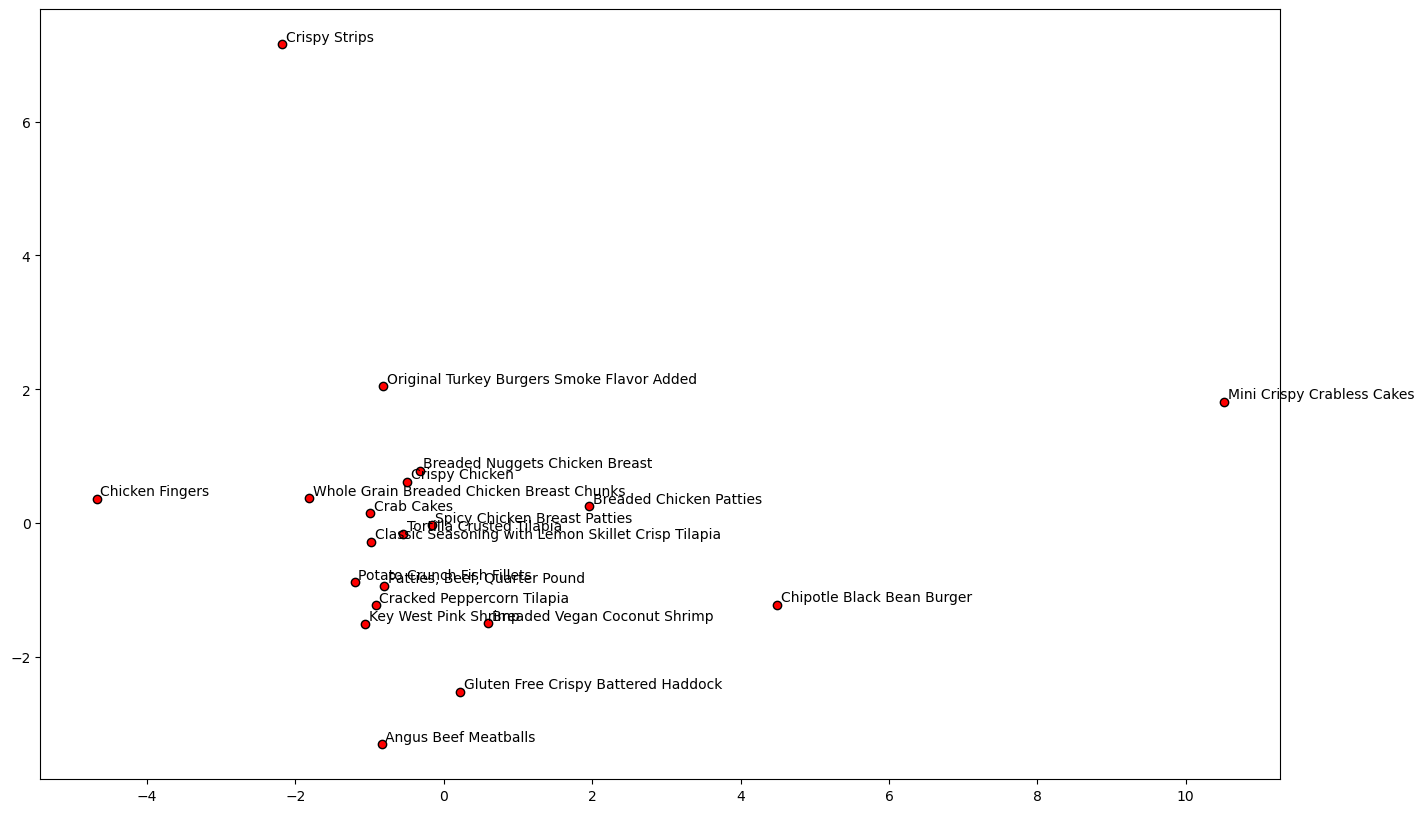

In [75]:
display_pca_scatterplot(model.wv, products_draw)
plt.show()

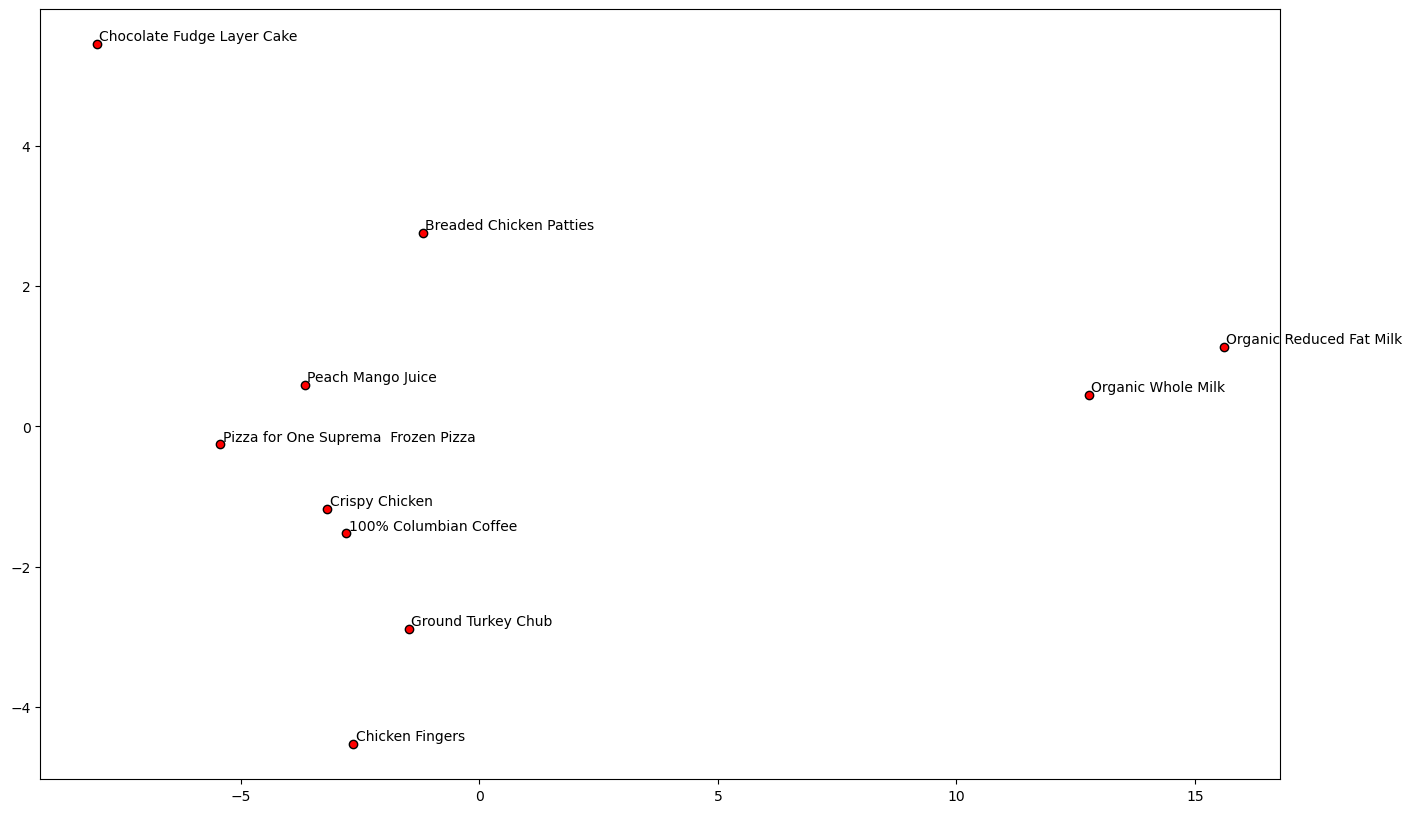

In [76]:
products_raw=['Peach Mango Juice',
'Chocolate Fudge Layer Cake',
'Pizza for One Suprema  Frozen Pizza',
'Chicken Fingers',
'100% Columbian Coffee',
'Breaded Chicken Patties',
'Organic Whole Milk','Organic Reduced Fat Milk',
'Crispy Chicken',
'Ground Turkey Chub']

display_pca_scatterplot(model.wv, products_raw)
plt.show()

In [77]:
df_of_basket_lists

order_id
1          [Cucumber Kirby, Bag of Organic Bananas, Organ...
2          [Organic Egg Whites, Michigan Organic Kale, Ca...
3          [Organic Ezekiel 49 Bread Cinnamon Raisin, Uns...
4          [Original Orange Juice, Kellogg's Nutri-Grain ...
5          [Biscuits Orange Pim's, Meyer Lemon, American ...
                                 ...                        
3421079                                      [Moisture Soap]
3421080    [Organic Apple Juice, Imported Butter, Organic...
3421081    [Hint of Lime Flavored Tortilla Chips, Healthy...
3421082    [Original Whipped Cream, Toasted Coconut Chips...
3421083    [Organic  Sweet & Salty Peanut Pretzel Granola...
Length: 3346083, dtype: object

In [78]:
# Calculation of the word embedding of a basket
def basket_embedding(basket):
    average_emb = np.zeros(embedding_size)
    for prod in basket:
        u = model.wv[prod]
        average_emb += u
        
    average_emb /= len(basket)
    return average_emb

In [79]:
basket_embedding(['Peach Mango Juice',
'Chocolate Fudge Layer Cake',
'Pizza for One Suprema  Frozen Pizza',
'Chicken Fingers',
'100% Columbian Coffee',
'Breaded Chicken Patties',
'Organic Whole Milk','Organic Reduced Fat Milk',
'Crispy Chicken',
'Ground Turkey Chub'])

array([-1.28522687,  0.92928977,  0.27509518,  0.48135341,  0.42370527,
       -0.23195807, -0.35077689, -2.01873805, -1.96688835,  0.07829562,
        0.47359998, -0.43995561,  1.27436245, -0.83051048])

In [80]:
df_baskets = df_of_basket_lists.to_frame().reset_index()
df_baskets.columns = ['order_id', 'products']

In [81]:
df_baskets

,order_id,products
0,1,"[Cucumber Kirby, Bag of Organic Bananas, Organ..."
1,2,"[Organic Egg Whites, Michigan Organic Kale, Ca..."
2,3,"[Organic Ezekiel 49 Bread Cinnamon Raisin, Uns..."
3,4,"[Original Orange Juice, Kellogg's Nutri-Grain ..."
4,5,"[Biscuits Orange Pim's, Meyer Lemon, American ..."
...,...,...
3346078,3421079,[Moisture Soap]
3346079,3421080,"[Organic Apple Juice, Imported Butter, Organic..."
3346080,3421081,"[Hint of Lime Flavored Tortilla Chips, Healthy..."
3346081,3421082,"[Original Whipped Cream, Toasted Coconut Chips..."


In [101]:
baskets

,order_id,product_name,Count
0,1670851,"Grapefruit, Bag",1
1,2354118,Pure & Natural Sour Cream,1
2,1331577,Sesame Seaweed Salad,1
3,216484,Half & Half,1
4,1613916,Via Italian Roast Instant Coffee,1
...,...,...,...
49680,554562,"Salsa, Black Bean",1
49681,1666202,Indian Wells Merlot,1
49682,2054334,Blackened Turkey,1
49683,828012,Hennepin Farmhouse Ale,1


In [82]:
df_baskets['embedding'] = df_baskets['products'].apply(basket_embedding)

In [83]:
df_baskets.columns

Index(['order_id', 'products', 'embedding'], dtype='object')

In [ ]:
import session_info
session_info.show(html=False)